In [1]:
from sklearn.datasets import load_files      
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.applications.xception import Xception, preprocess_input
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.applications.vgg19 import VGG19, preprocess_input

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Work around GPU memory issues…import tensorflow as tf…import keras.backend.tensorflow_backend as ktf
#import tensorflow as tf
#import keras.backend.tensorflow_backend as ktf

#def get_session(gpu_fraction=0.6):
#    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
#                                allow_growth=True)
#    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#ktf.set_session(get_session())

In [3]:
img_width, img_height = 224, 224 # change based on the shape/structure of your images

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    fire_files = np.array(data['filenames'])
    fire_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return fire_files, fire_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('fireImages/train')
valid_files, valid_targets = load_dataset('fireImages/valid')
test_files, test_targets = load_dataset('fireImages/test')

# load list of fire classes
class_names = [item[21:-1] for item in sorted(glob("fireImages/train/*/"))]

# print statistics about the dataset
print('There are %d total fire categories.' % len(class_names))
print('There are %s total fire images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training fire images.' % len(train_files))
print('There are %d validation fire images.' % len(valid_files))
print('There are %d test fire images.'% len(test_files))

There are 3 total fire categories.
There are 319 total fire images.

There are 166 training fire images.
There are 89 validation fire images.
There are 64 test fire images.


In [4]:
class_names

['Fire', 'Smoke', 'Safe']

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
from PIL import ImageFile       
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = preprocess_input( paths_to_tensor(train_files) )
valid_tensors = preprocess_input( paths_to_tensor(valid_files) )
test_tensors  = preprocess_input( paths_to_tensor(test_files) )

100%|██████████| 64/64 [00:00<00:00, 225.55it/s]


### Detect fire with the most accurate model

In [7]:
### Define the architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import applications

from keras.applications.resnet50 import preprocess_input, decode_predictions
VGG16_model       = applications.VGG16(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
InceptionV3_model = applications.InceptionV3(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
Xception_model    = applications.Xception(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
ResNet50_model    = applications.ResNet50(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)
VGG19_model       = applications.VGG19(input_shape=(img_width, img_height, 3), weights = "imagenet", include_top=False)

### Pick the most accurate model for this application

In [8]:
#base_model = InceptionV3_model
#base_model = Xception_model
base_model = ResNet50_model
#base_model = VGG16_model
#base_model = VGG19_model

### Transfer learning (freeze base model layers)

In [9]:
# Freeze the layers which you don't want to train. 
for layer in base_model.layers:
    layer.trainable = False

# Here I am freezing the first 5 layers.
# for layer in model.layers[:5]:
#    layer.trainable = False

In [10]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.45)(x)
# and a logistic layer we have 133 classes
predictions = Dense(133, activation='softmax')(x)

In [11]:
from keras.models import Model
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [14]:
from keras.callbacks import ModelCheckpoint   

import keras.backend.tensorflow_backend as K

# train the model
checkpointer = ModelCheckpoint(filepath='firemodel.weights.best.hdf5', verbose=3, save_best_only=True)
hist = model.fit(train_tensors, train_targets, batch_size=64, epochs=20,
      validation_data=(valid_tensors, valid_targets), callbacks=[checkpointer], 
      verbose=2)  #, shuffle=True)

Train on 166 samples, validate on 89 samples
Epoch 1/20
Epoch 00001: val_loss improved from inf to 1.03734, saving model to firemodel.weights.best.hdf5
 - 8s - loss: 2.8977 - acc: 0.2771 - val_loss: 1.0373 - val_acc: 0.6067
Epoch 2/20
Epoch 00002: val_loss did not improve
 - 2s - loss: 1.0408 - acc: 0.6747 - val_loss: 1.2893 - val_acc: 0.4270
Epoch 3/20
Epoch 00003: val_loss improved from 1.03734 to 0.50274, saving model to firemodel.weights.best.hdf5
 - 2s - loss: 0.6339 - acc: 0.7651 - val_loss: 0.5027 - val_acc: 0.8427
Epoch 4/20
Epoch 00004: val_loss did not improve
 - 1s - loss: 0.5194 - acc: 0.7892 - val_loss: 0.8153 - val_acc: 0.6742
Epoch 5/20
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.5115 - acc: 0.7892 - val_loss: 0.6549 - val_acc: 0.7191
Epoch 6/20
Epoch 00006: val_loss did not improve
 - 1s - loss: 0.3806 - acc: 0.8494 - val_loss: 0.6902 - val_acc: 0.7079
Epoch 7/20
Epoch 00007: val_loss did not improve
 - 2s - loss: 0.3509 - acc: 0.8494 - val_loss: 0.6417 - val_

In [15]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

(0, 'input_4')
(1, 'conv1')
(2, 'bn_conv1')
(3, 'activation_95')
(4, 'max_pooling2d_5')
(5, 'res2a_branch2a')
(6, 'bn2a_branch2a')
(7, 'activation_96')
(8, 'res2a_branch2b')
(9, 'bn2a_branch2b')
(10, 'activation_97')
(11, 'res2a_branch2c')
(12, 'res2a_branch1')
(13, 'bn2a_branch2c')
(14, 'bn2a_branch1')
(15, 'add_13')
(16, 'activation_98')
(17, 'res2b_branch2a')
(18, 'bn2b_branch2a')
(19, 'activation_99')
(20, 'res2b_branch2b')
(21, 'bn2b_branch2b')
(22, 'activation_100')
(23, 'res2b_branch2c')
(24, 'bn2b_branch2c')
(25, 'add_14')
(26, 'activation_101')
(27, 'res2c_branch2a')
(28, 'bn2c_branch2a')
(29, 'activation_102')
(30, 'res2c_branch2b')
(31, 'bn2c_branch2b')
(32, 'activation_103')
(33, 'res2c_branch2c')
(34, 'bn2c_branch2c')
(35, 'add_15')
(36, 'activation_104')
(37, 'res3a_branch2a')
(38, 'bn3a_branch2a')
(39, 'activation_105')
(40, 'res3a_branch2b')
(41, 'bn3a_branch2b')
(42, 'activation_106')
(43, 'res3a_branch2c')
(44, 'res3a_branch1')
(45, 'bn3a_branch2c')
(46, 'bn3a_branch1

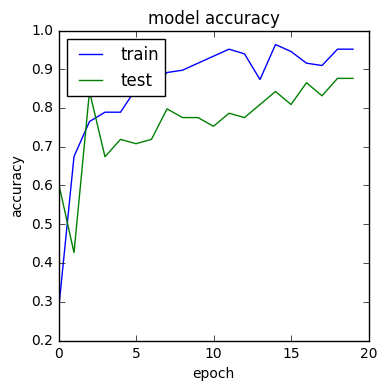

In [16]:
import cv2                
import matplotlib.pyplot as plt                        

# summarize history for accuracy
plt.figure(figsize=(4,4), dpi=100 )
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('training1.png', dpi=300)

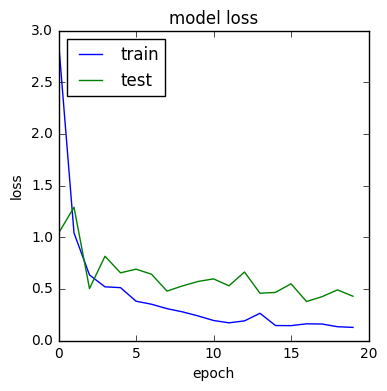

In [17]:
# summarize history for loss
plt.figure(figsize=(4,4), dpi=100 )
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Load the Model with the Best Validation Loss

In [18]:
### Load the model weights with the best validation loss.
model.load_weights('firemodel.weights.best.hdf5')

### Test the Fire detection Model

In [19]:
### Calculate classification accuracy on the test dataset.

# get index of predicted fire class for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

In [20]:
# report test accuracy
test_accuracy = 100*np.sum ( np.array( predictions)==np.argmax(test_targets, axis=1) ) / len(predictions )
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 93.0000%


In [21]:
# test validation accuracy
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in valid_tensors]
valid_accuracy = 100*np.sum ( np.array( predictions)==np.argmax(valid_targets, axis=1) ) / len(predictions )
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 86.0000%


In [22]:
def detect_fire(img_path):
    predicted_vector = model.predict(preprocess_input(path_to_tensor(img_path)))
    return class_names[np.argmax(predicted_vector)]

_____________________________________________________________________________________________

ALARM: Detected Smoke


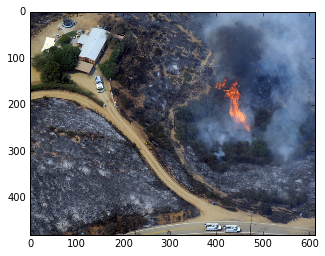

_____________________________________________________________________________________________

ALARM: Detected Smoke


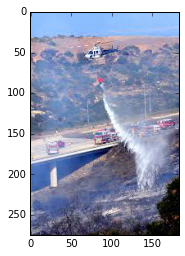

_____________________________________________________________________________________________

Looking good: Safe


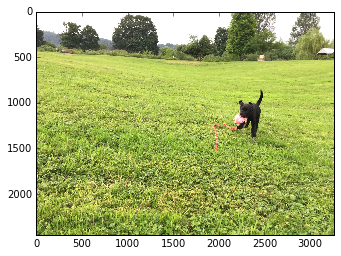

_____________________________________________________________________________________________

ALARM: Detected Fire


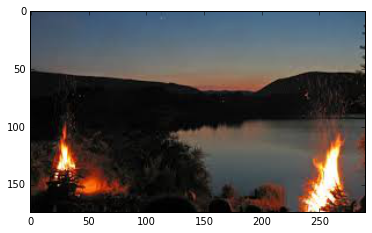

_____________________________________________________________________________________________

ALARM: Detected Fire


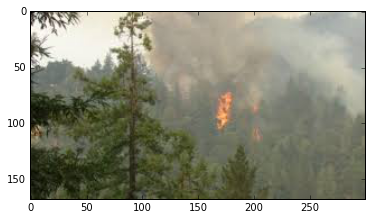

_____________________________________________________________________________________________

ALARM: Detected Fire


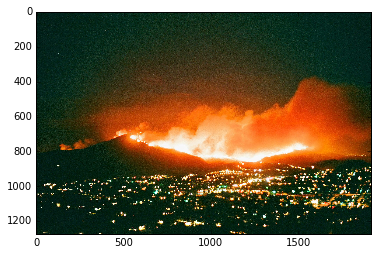

_____________________________________________________________________________________________

ALARM: Detected Fire


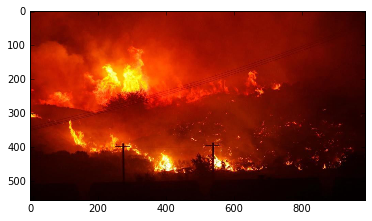

_____________________________________________________________________________________________

ALARM: Detected Fire


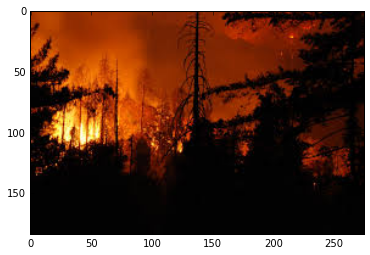

_____________________________________________________________________________________________

ALARM: Detected Fire


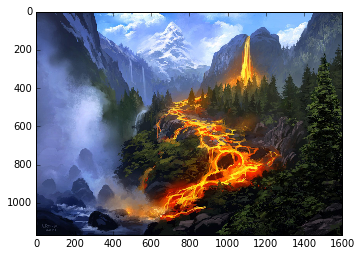

In [23]:
import glob
from PIL import Image 
from IPython import display

path = "test_images/*"
for fname in glob.glob(path):
    fire_detection = detect_fire( fname )
    display.display(plt.gcf())
    print('_____________________________________________________________________________________________')
    print('')
    if (fire_detection=='Fire'):
        print ('\033[1m'+'\033[91m'+'ALARM: Detected '+fire_detection.replace("_", ""))
    elif (fire_detection=='Smoke'):
        print ('\033[1m'+'\033[91m'+'ALARM: Detected '+fire_detection.replace("_", ""))
    else:
        print ('\033[1m'+'\033[92m'+'Looking good: ' +fire_detection.replace("_", ""))
    plt.imshow(Image.open(fname))
    #raw_input()
